# LFW Visualize

In [11]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils
from app.models.bbox import BBox

In [124]:
# function to create spaced colormaps as RGB values

import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors

def jitter_clr(clr, amt=10, mono=False):
  clr = list(clr)
  if mono:
    r = randint(-amt, amt)
    for i in range(len(clr)):
      clr[i] = max(0, min(255, clr[i] + r))
  else:
    for i in range(len(clr)):
      r = randint(-amt, amt)
      clr[i] = max(0, min(255, clr[i] + r))
  return clr

def random_color():
  return tuple(map(int, np.random.choice(range(256), size=3)))

In [6]:
DATA_STORE = '/data_store_nas/'
fp_dataset = join(DATA_STORE, 'datasets/people/lfw')

DATA_STORE_HDD = '/data_store_hdd/'
fp_rois = join(DATA_STORE_HDD, 'apps/megapixels/datasets/people/lfw/rois.csv')

In [7]:
df_rois = pd.read_csv(fp_rois)
df_rois.head()

Unnamed: 0   ext                    fn         h         w         x  \
0           0  .jpg          AJ_Cook_0001  0.330000  0.330000  0.336667   
1           1  .jpg         AJ_Lamas_0001  0.393333  0.393333  0.286667   
2           2  .jpg    Aaron_Eckhart_0001  0.393333  0.393333  0.286667   
3           3  .jpg      Aaron_Guiel_0001  0.393333  0.393333  0.286667   
4           4  .jpg  Aaron_Patterson_0001  0.393333  0.393333  0.286667   

          y  
0  0.350000  
1  0.313333  
2  0.273333  
3  0.313333  
4  0.273333

In [105]:
rois = {}
for idx, row in df_rois.iterrows():
  x, y, w, h = row['x'], row['y'], row['w'], row['h']
  rois[row['fn'].lower()] = BBox.from_xywh(x, y, w, h)
print(len(rois))

13230


In [101]:
colors = get_color_map(cmap='winter', ncolors=len(rois), reverse=False)

 Colormap PiYGF is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [120]:
random_color()

(47, 139, 95)

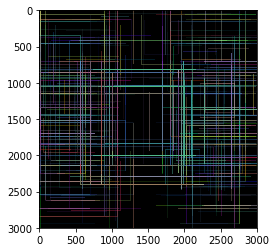

In [138]:
# draw it
im = np.zeros([3000, 3000, 3]).astype(np.uint8)
im_blank = im.copy()
im[::] = (0,0,0)
limit = 12000
stroke_weight = 2

h, w = im.shape[:2]
for i, roi in enumerate(tqdm(rois.items())):
  fname, bbox = roi  # expand
  bbox = bbox.to_dim((w,h))
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_cp = im.copy()
  cv.rectangle(im_cp, pt1, pt2, jitter_clr(colors[i]), stroke_weight, cv.LINE_AA,)
  rn = random_color()
  cv.rectangle(im_cp, pt1, pt2, rn, stroke_weight, cv.LINE_AA,)
  im = cv.addWeighted(im_cp, 0.3, im, .7, 0)
  if i > limit:
    break

    
cv.imwrite('output/lfw_rand.png', im)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))

In [108]:
from time import sleep

In [110]:
for j in tqdm(range(100), desc='2nd loop'):
  sleep(0.01)